In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Interlub/

 clean_data.csv		      Forecasting.ipynb		   orders_preprocessed.csv
 clean_data_no_outliers.csv   ForecastingWEEKS.ipynb	   orders_preprocessed_top_items.csv
 DataCleaning_guide.ipynb     Inventory_prediction.ipynb   orders_weeks.csv
 DataCleaning.ipynb	     'Linear Regression.ipynb'	   Preprocessing.ipynb
 DataHackathon.xlsx	      Model_Comparison.ipynb	   TimeSeries1.ipynb


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Interlub/clean_data.csv')
df_no_outliers = pd.read_csv('/content/drive/MyDrive/Interlub/clean_data_no_outliers.csv')
df.head()

Aggregating for daily orders per product

In [ ]:
total_orders_df = df.drop(columns=['Orden de Venta', 'Codigo Cliente'])
total_orders_df_no_outliers = df_no_outliers.drop(columns=['Orden de Venta', 'Codigo Cliente'])
agg_rules = {
    'Cantidad': 'sum',  # Sum the quantity
    'Unidad de venta': lambda x: x.mode()[0] if not x.mode().empty else None  # Mode for categorical data
}
aggregated_df = total_orders_df.groupby(['Creacion Orden de Venta', 'Articulo'], as_index=False).agg(agg_rules)
aggregated_df_no_outliers = total_orders_df_no_outliers.groupby(['Creacion Orden de Venta', 'Articulo'], as_index=False).agg(agg_rules)
aggregated_df.head()

In [ ]:
# Ensure data is sorted by date (important for time series split)
aggregated_df = aggregated_df.sort_values(['Articulo', 'Creacion Orden de Venta'])
aggregated_df_no_outliers = aggregated_df_no_outliers.sort_values(['Articulo', 'Creacion Orden de Venta'])

# Filter product_ids that appear more than 60 times
df_filtered = aggregated_df.groupby('Articulo').filter(lambda x: len(x) >= 200)

df_filtered_no_outliers = aggregated_df_no_outliers.groupby('Articulo').filter(lambda x: len(x) >= 200)
df_filtered.head()

In [ ]:
df_filtered.shape

(3406, 4)

In [ ]:
df_filtered_no_outliers.shape

(2849, 4)

In [ ]:
df_filtered_no_outliers['Articulo'].value_counts()

In [ ]:
# Get first and last date per product_id
product_dates = df_filtered_no_outliers.groupby('Articulo')['Creacion Orden de Venta'].agg(['min', 'max']).reset_index()
pd.set_option("display.max_rows", None)
print(product_dates.head())

In [ ]:
df_filtered_no_outliers = df_filtered_no_outliers.rename(columns={"Creacion Orden de Venta": "date", "Articulo": "product_id", "Unidad de venta": "unit", "Cantidad":"quantity"})

In [ ]:
df_filtered_no_outliers['date'] = pd.to_datetime(df_filtered_no_outliers['date'])
df_filtered_no_outliers.head()

In [ ]:
# Define full date range
full_date_range = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')

# Get unique products
products = df_filtered_no_outliers['product_id'].unique()

# Create a DataFrame with all combinations of dates and products
full_df = pd.DataFrame({
    'date': np.repeat(full_date_range, len(products)),
    'product_id': np.tile(products, len(full_date_range))
})

# Merge with the original DataFrame to find missing dates
merged_df = full_df.merge(df_filtered_no_outliers, on=['date', 'product_id'], how='left')

# Fill missing values
merged_df['unit'] = merged_df.groupby('product_id')['unit'].transform(lambda x: x.fillna(x.mode().iloc[0]))
merged_df['quantity'] = merged_df['quantity'].fillna(0)

# Sort the DataFrame by product and date
merged_df = merged_df.sort_values(by=['product_id', 'date']).reset_index(drop=True)

# Sort the DataFrame by product and date
merged_df = merged_df.sort_values(by=['product_id', 'date']).reset_index(drop=True)

print(merged_df.head())

In [ ]:
# Display result
print(merged_df['product_id'].value_counts())  # View first 10 row

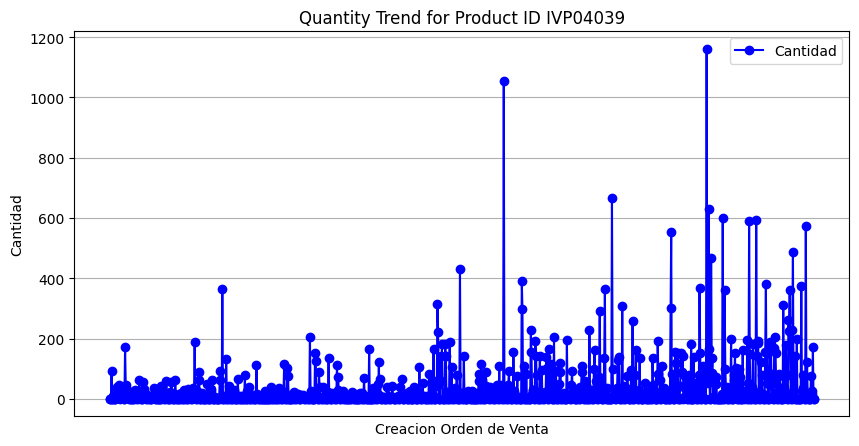

In [ ]:
import matplotlib.pyplot as plt
# Filter for product_id 'IVP04039' example dummy product
max_product_df = merged_df[merged_df['product_id'] == 'IVP04039'].sort_values('date')

# Plot the line graph
plt.figure(figsize=(10, 5))
plt.plot(max_product_df['date'], max_product_df['quantity'], marker='o', linestyle='-', color='b', label='Cantidad')

# Formatting the plot
plt.xlabel('Creacion Orden de Venta')
plt.ylabel('Cantidad')
plt.title('Quantity Trend for Product ID IVP04039')
plt.xticks([])  # Hides x-axis labels
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
merged_df['quantity'].mean()

np.float64(48.86037544393709)

In [ ]:
merged_df.to_csv("orders_preprocessed_top_items.csv", index=False)